# Actions chaining tutorial

In [69]:
import os
import sys
import math

# used for printing info about batch data
from tabulate import tabulate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [70]:
# specify spacing format in table
def format_spacing(float_list):
    return '(' + ', '.join(['{:.2f}'.format(e) for e in float_list]) + ')'

# specify origin format in table
def format_origin(float_list):
    return '(' + ', '.join(['{:.1f}'.format(e) for e in float_list]) + ')'


# plot central slice of batch component(default component is 'images')
def plot_central_slice(batch, component='images'):
    num_cols = 3
    num_rows = math.ceil(len(batch) / 3)
    plt.figure(figsize=(15, 5))
    for i in range(len(batch)):
        plt.subplot('{}{}{}'.format(num_rows, num_cols, i))
        plt.imshow(batch.get(i, component)[math.floor(batch.images_shape[i, 0] / 2), ...])


# show info about data contained in batch as a tabulate table
def show_info(batch, index_visualize_len=10):
    tab_data = []
    for e, index in enumerate(batch.indices):
        tab_data.append(['...' + str(index[-index_visualize_len:]),
                        tuple(batch.images_shape[e, :].tolist()),
                        '+' if getattr(batch, 'images') is not None else '-',
                        '+' if getattr(batch, 'masks') is not None else '-',
                        format_spacing(batch.spacing[e, :].tolist()),
                        format_origin(batch.origin[e, :].tolist())
                        ])

    print(tabulate(tab_data, headers=['Index:', 'Shape:', 'Images:', 'Masks:', 'Spacing:', 'Origin:'],
                   tablefmt='orgtbl', stralign='center') + '\n\n' + super(type(batch), batch).__repr__())

## Working with luna dataset

### First import CTImagesMaskedBatch and dataset from radio

In [71]:
import radio
from radio import batchflow as bf
from radio import CTImagesMaskedBatch as CTIMB

### Creating index and dataset instances for luna *.mhd files

In [72]:
nodules = pd.read_csv('/notebooks/data/MRT/luna/CSVFILES/annotations.csv')
luna_index = bf.FilesIndex(path='/notebooks/data/MRT/luna/*/*.mhd', no_ext=True)
luna_set = bf.Dataset(luna_index, batch_class=CTIMB)

print("LUNA dataset contains {} CT-scans".format(len(luna_set)))

LUNA dataset contains 888 CT-scans


## What is inside CTImagesMaskedBatch?

In [73]:
batch = luna_set.next_batch(2)

### Components and actions

In [74]:
batch.components, []

('images', 'masks', 'spacing', 'origin')

### Chaining actions in pipelines

In [93]:
batch = luna_set.next_batch(2)
batch = batch.load(fmt='raw')
batch = batch.normalize_hu()

### Cetral slice before resize action is called

|    Index:     |     Shape:      |  Images:  |  Masks:  |      Spacing:      |         Origin:          |
|---------------+-----------------+-----------+----------+--------------------+--------------------------|
| ...2147226290 | (144, 512, 512) |     +     |    -     | (2.50, 0.78, 0.78) | (-362.8, -200.0, -191.2) |
| ...8566429132 | (326, 512, 512) |     +     |    -     | (1.00, 0.55, 0.55) | (-506.6, -277.7, -135.7) |



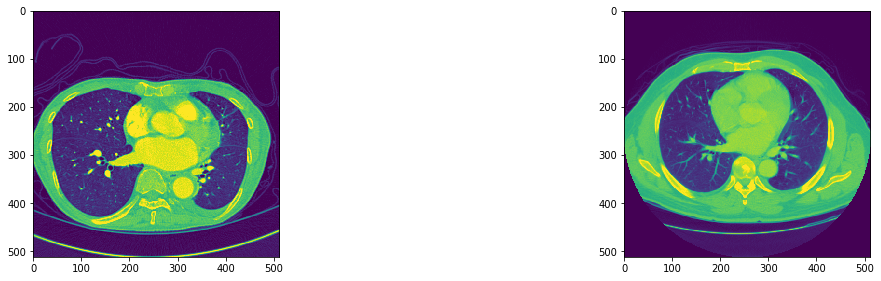

In [94]:
show_info(batch)
plot_central_slice(batch)

### Scans after resize action

|    Index:     |     Shape:      |  Images:  |  Masks:  |      Spacing:      |         Origin:          |
|---------------+-----------------+-----------+----------+--------------------+--------------------------|
| ...2147226290 | (400, 512, 512) |     +     |    -     | (0.90, 0.78, 0.78) | (-362.8, -200.0, -191.2) |
| ...8566429132 | (400, 512, 512) |     +     |    -     | (0.81, 0.55, 0.55) | (-506.6, -277.7, -135.7) |



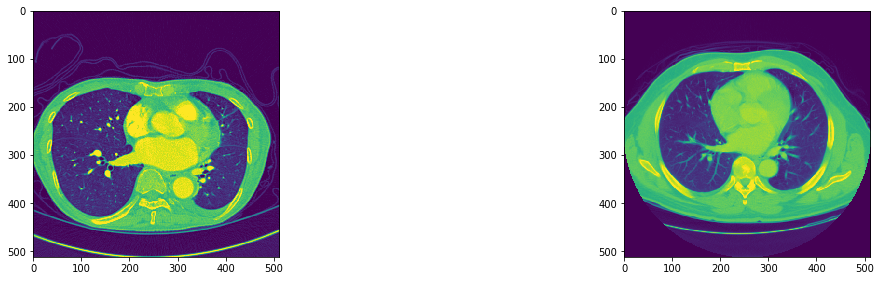

In [95]:
batch_resize = batch.resize(shape=(400, 512, 512))

show_info(batch_resize)
plot_central_slice(batch_resize)

### Scans after unify_spacing action

|    Index:     |     Shape:      |  Images:  |  Masks:  |      Spacing:      |         Origin:          |
|---------------+-----------------+-----------+----------+--------------------+--------------------------|
| ...2147226290 | (400, 512, 512) |     +     |    -     | (1.70, 1.00, 1.00) | (-522.4, -256.0, -247.2) |
| ...8566429132 | (400, 512, 512) |     +     |    -     | (1.70, 1.00, 1.00) | (-683.2, -393.7, -251.7) |



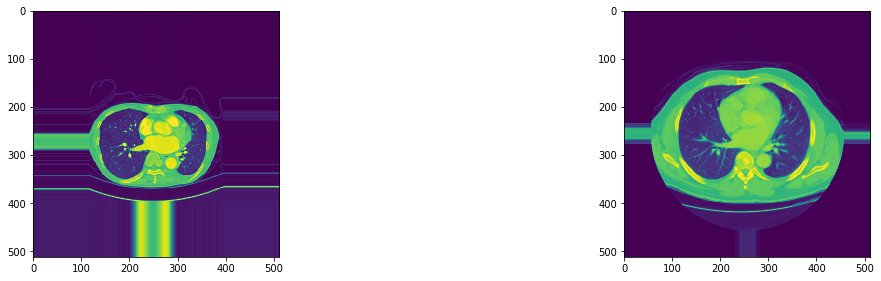

In [97]:
batch_unify_spacing = batch.unify_spacing(shape=(400, 512, 512), spacing=(1.7, 1.0, 1.0), padding='reflect')

show_info(batch_unify_spacing)
plot_central_slice(batch_unify_spacing)

### Fetching information about nodules location from annotation and masks creation

In [98]:
batch = batch_unify_spacing

batch = batch.fetch_nodules_info(nodules)
batch = batch.create_mask()
show_info(batch)

|    Index:     |     Shape:      |  Images:  |  Masks:  |      Spacing:      |         Origin:          |
|---------------+-----------------+-----------+----------+--------------------+--------------------------|
| ...2147226290 | (400, 512, 512) |     +     |    +     | (1.70, 1.00, 1.00) | (-522.4, -256.0, -247.2) |
| ...8566429132 | (400, 512, 512) |     +     |    +     | (1.70, 1.00, 1.00) | (-683.2, -393.7, -251.7) |



### Visualizing batch with sampled nodules

|    Index:     |    Shape:    |  Images:  |  Masks:  |      Spacing:      |         Origin:         |
|---------------+--------------+-----------+----------+--------------------+-------------------------|
| ...0_ac4cec20 | (32, 64, 64) |     +     |    +     | (1.70, 1.00, 1.00) |  (-187.8, -72.0, 81.8)  |
| ...0_4ec5cf99 | (32, 64, 64) |     +     |    +     | (1.70, 1.00, 1.00) | (-237.1, -96.0, -104.2) |
| ...0_a9f3b1fd | (32, 64, 64) |     +     |    +     | (1.70, 1.00, 1.00) | (-179.4, -52.0, -82.2)  |



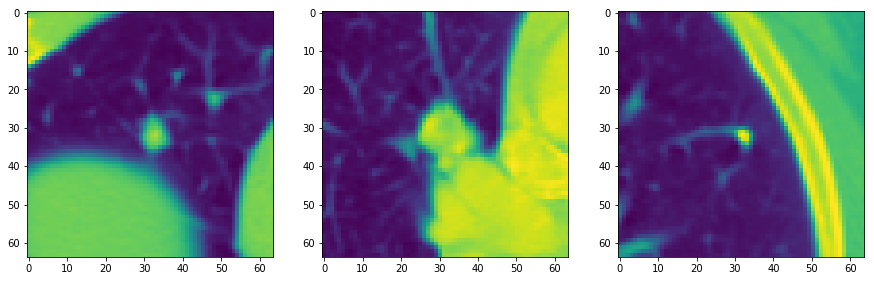

In [99]:
batch_nodules = batch.sample_nodules(nodule_size=(32, 64, 64), batch_size=None, share=1.0)
show_info(batch_nodules)
plot_central_slice(batch_nodules)

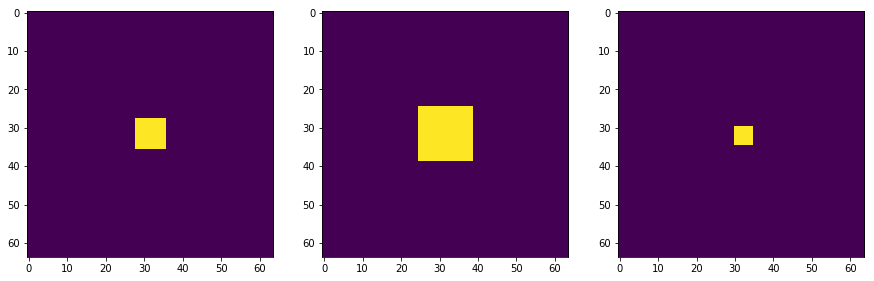

In [100]:
plot_central_slice(batch_nodules, 'masks')

## All these action calls can be expressively chained in one pipeline

In [101]:
luna_ppl = luna_set >> (
    bf.Pipeline()
      .load(fmt='raw')
      .normalize_hu()
      .unify_spacing(shape=(128, 256, 256), spacing=(1.7, 1.0, 1.0), padding='reflect')
      .fetch_nodules_info(nodules)
      .create_mask()
      .sample_nodules(nodule_size=(32, 64, 64), batch_size=6, share=0.4)
)

### Pipeline's next_batch method returns batch after applying all preprocessing operations:

In [103]:
batch = luna_ppl.next_batch(batch_size=2)
show_info(batch)

|    Index:     |    Shape:    |  Images:  |  Masks:  |      Spacing:      |        Origin:         |
|---------------+--------------+-----------+----------+--------------------+------------------------|
| ...1_900fda91 | (32, 64, 64) |     +     |    +     | (1.70, 1.00, 1.00) | (-185.1, 355.0, 260.2) |
| ...1_48545dd3 | (32, 64, 64) |     +     |    +     | (1.70, 1.00, 1.00) | (-171.5, 309.0, 363.2) |
| ...1_240b8bcf | (32, 64, 64) |     +     |    +     | (1.70, 1.00, 1.00) | (-190.2, 246.0, 221.2) |
| ...9_9fd9010e | (32, 64, 64) |     +     |    +     | (1.70, 1.00, 1.00) | (-280.7, 13.9, -89.0)  |
| ...1_90a6d30b | (32, 64, 64) |     +     |    +     | (1.70, 1.00, 1.00) | (-149.4, 281.0, 276.2) |
| ...9_082b75c6 | (32, 64, 64) |     +     |    +     | (1.70, 1.00, 1.00) | (-219.3, 12.9, -63.0)  |



### Pipeline's gen_batch method returns iterator:

In [104]:
for i, batch in zip(range(4), luna_ppl.gen_batch(batch_size=1)):
    print("Iteration: {}".format(i))
    print(batch)
    print("======================")

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


### Both next_batch and gen_batch methods have prefetch argument alowing interbatch parallelism:

In [113]:
from time import time
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

before = time()
for i, batch in zip(range(8), luna_ppl.gen_batch(batch_size=1, prefetch=4)):
    after = time()
    print("Iteration: {}  Time for iteration: {}".format(i, after - before))
    before = after
    print(batch)
    print("======================")

Iteration: 0  Time for iteration: 9.168249130249023
Iteration: 1  Time for iteration: 8.957867860794067
Iteration: 2  Time for iteration: 0.0007700920104980469
Iteration: 3  Time for iteration: 0.005591392517089844
Iteration: 4  Time for iteration: 0.0012559890747070312
Iteration: 5  Time for iteration: 0.0009076595306396484
Iteration: 6  Time for iteration: 13.243481397628784
Iteration: 7  Time for iteration: 0.0005908012390136719
